# YOLO v11 訓練偵測發票模型


In [ ]:
!nvidia-smi

Mon Jun 30 03:13:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!nvcc -V

連線google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content
import os
HOME = os.getcwd()
print(HOME)

/content
/content


In [ ]:
%%capture
!pip install ultralytics

import ultralytics
ultralytics.checks()

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image

載入datasets

In [ ]:
%cd {HOME}
!rm -r datasets
!mkdir datasets
%cd datasets

!pip install roboflow

datasets_version = 17

from roboflow import Roboflow
rf = Roboflow(api_key="你自己的API key") # 找 Roboflow 申請帳號
project = rf.workspace("hello-world-iqdze").project("invoice-nk2ns")
version = project.version(datasets_version)
dataset = version.download("yolov11")

# 第一次都會要restart 最好restart後從頭都再執行一遍

%cd {HOME}

/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to Invoice-17 in yolov11:: 100%|██████████| 288/288 [00:00<00:00, 3564.70it/s]


# 解決roboflow問題

註解pillow_heif.register_avif_opener(thumbnails=False)  \# Register for AVIF
以防報錯

In [ ]:
# @title 目前無此問題
%cd /usr/local/lib/python3.11/dist-packages/roboflow/util

def fix():
  with open('image_utils.py', 'w') as img_py:
    img_py.write('''# Standard library imports
  import base64
  import io
  import os
  import urllib

  # Third-party imports
  import pillow_heif  # type: ignore[import-untyped]
  import requests
  import yaml
  from PIL import Image

  pillow_heif.register_heif_opener(thumbnails=False)  # Register for HEIF/HEIC
  #pillow_heif.register_avif_opener(thumbnails=False)  # Register for AVIF


  def check_image_path(image_path):
      """
      Check whether a local OR hosted image path is valid
      :param image_path: local path or URL of image
      :returns: Boolean
      """
      return os.path.exists(image_path) or check_image_url(image_path)


  def check_image_url(url):
      """
      Check whether a hosted image path is valid
      :param url: URL of image
      :returns: Boolean
      """
      if urllib.parse.urlparse(url).scheme not in ("http", "https"):
          return False

      r = requests.head(url)
      return r.status_code == requests.codes.ok


  def mask_image(image, encoded_mask, transparency=60):
      """
      Overlay a translucent mask on top of an image with CV2
      :param image: a CV2 image / numpy.ndarray matrix
      :param encoded_mask: a base64 encoded single channel image
      :param transparency: alpha transparency of masks for semantic overlays
      :returns: CV2 image / numpy.ndarray matrix
      """
      import cv2
      import numpy as np

      np_data = np.fromstring(base64.b64decode(encoded_mask), np.uint8)  # type: ignore[no-overload]
      mask = cv2.imdecode(np_data, cv2.IMREAD_UNCHANGED)

      # Fallback in case the API returns an incorrectly sized mask
      # This should not happen in practice, but we saw it in testing
      image_size = image.shape[1::-1]
      mask_size = mask.shape[1::-1]
      if mask_size != image_size:
          mask = cv2.resize(mask, image_size)

      # Mask the original image
      masked = cv2.bitwise_and(image, image, mask=mask)

      # Overlay a translucent version of the original image
      # on top of the masked image to give it a translucent effect
      alpha = transparency / 100
      return cv2.addWeighted(masked, alpha, image, 1 - alpha, 0)


  def validate_image_path(image_path):
      """
      Validate whether a local OR hosted image path is valid
      :param image_path: local path or URL of image
      :returns: None
      :raises Exception: Image path is not valid
      """
      if not check_image_path(image_path):
          raise Exception(f"Image does not exist at {image_path}!")


  def file2jpeg(image_path):
      import cv2

      # OpenCV will handle standard formats efficiently
      img = cv2.imread(image_path)
      if img is not None:
          # Convert BGR to RGB for PIL
          image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          pilImage = Image.fromarray(image)
      else:
          # If OpenCV fails, the format might be HEIC/AVIF which are handled by PIL
          pilImage = Image.open(image_path)
          if pilImage.mode != "RGB":
              pilImage = pilImage.convert("RGB")

      buffered = io.BytesIO()
      pilImage.save(buffered, quality=100, format="JPEG")
      return buffered.getvalue()


  def load_labelmap(f):
      if f.lower().endswith(".yaml") or f.lower().endswith(".yml"):
          with open(f) as file:
              data = yaml.safe_load(file)
              if "names" in data:
                  return {i: name for i, name in enumerate(data["names"])}
      else:
          with open(f) as file:
              lines = [line for line in file.readlines() if line.strip()]
          return {i: line.strip() for i, line in enumerate(lines)}
  ''')

fix()

/usr/local/lib/python3.11/dist-packages/roboflow/util


# 儲存 要保留的訓練

In [ ]:
val = '_seg'
version = '1' # 自行修改，會影響 訓練要載入的模型 和 訓練完要儲存的名稱，要存新檔案才須改

best_name = f"best{val}.pt" # best_name = best_seg.pt
last_name = f"last{val + version}.pt" # last_name = last_seg + 版本.pt

- 電子發票儲存位置

In [ ]:
# 存在model_1資料夾 model_version就等於 1; 存在model_2資料夾 model_version就等於 2; 依此類推
model_version = 1

# 儲存最新訓練出的 best.pt 如果有新的 會把目前裡面的移到外面 history_path 把最新的存進來
save_path = f'/content/drive/MyDrive/sharingColab/invoice/model_{model_version}/latest'

# 儲存 last.pt 和 舊的 best.pt
history_path = f'/content/drive/MyDrive/sharingColab/invoice/model_{model_version}'

**儲存模型 (以下兩個cell訓練完才須執行)**

In [ ]:
drive.mount('/content/drive/', force_remount=True)
%mv {save_path}/best_seg.pt {history_path}/best_seg{int(version)-1}.pt # 把舊的 best.pt 改名移到 history_path

Mounted at /content/drive/


In [ ]:
!cp '/content/runs/segment/train/weights/best.pt' {save_path + '/' + best_name} # 把最新 best.pt 存到 save_path 並改名
!cp '/content/runs/segment/train/weights/last.pt' {history_path + '/' + last_name} # 把最新 last.pt 存到 history_path 並改名

<br>

# 修改 和 儲存 folder 名稱

In [ ]:
train_times = 1 # 僅第一次連線進來需要執行 會影響train改名後的名稱

In [ ]:
MyDrive_best_pt_path = f'{save_path}/{best_name}' # 定義訓練要載入之 best 模型路徑
MyDrive_last_pt_path = f'{history_path}/{last_name}' # 定義訓練要載入之 last 模型路徑

修改 train 和 predict 資料夾名稱 (以下3個cell訓練完才須執行)\
yolo 訓練完會自動儲存模型到 runs/segment/train\
如果 train 已存在就會存到 train2 如果也存在就會到 train3 以此類推\
所以訓練完直接把 train 改成 train_1 下一次訓練完 yolo 就只會建一個 train 資料夾做儲存

In [ ]:
%cd {HOME}/runs/segment

trained_name = f"train_{train_times}"
predicted_name = f"predict_{train_times}"

!mv train {trained_name}
!mv predict {predicted_name}

/content/runs/segment


In [ ]:
train_best_pt_path = f"/content/runs/segment/{trained_name}/weights/best.pt"
train_last_pt_path = f"/content/runs/segment/{trained_name}/weights/last.pt"

In [ ]:
train_times += 1

In [ ]:
train_times

3

# Python API 寫法

In [ ]:
yoloModel = YOLO(MyDrive_last_pt_path)
yoloModel.train(
    data = f"{dataset.location}/data.yaml",
    epochs = 50,
    batch = 24,
    cache = True,
    imgsz = 640
)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/catANDdog-10/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/sharingColab/yolo11/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              


  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  2   1455616  ultralytics.nn.modules.block.C2PSA           [512, 512, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   2496512  ultralytics.nn.modules.block.C3k2            [1024, 512, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

100%|██████████| 5.35M/5.35M [00:00<00:00, 94.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 811.6±368.2 MB/s, size: 38.2 KB)


train: Scanning /content/datasets/catANDdog-10/train/labels... 342 images, 0 backgrounds, 0 corrupt: 100%|██████████| 342/342 [00:00<00:00, 2049.87it/s]

train: New cache created: /content/datasets/catANDdog-10/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 342/342 [00:01<00:00, 305.25it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 527.0±365.2 MB/s, size: 43.7 KB)


val: Scanning /content/datasets/catANDdog-10/valid/labels... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<00:00, 980.14it/s]

val: New cache created: /content/datasets/catANDdog-10/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 53/53 [00:00<00:00, 160.41it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005625000000000001), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      14.4G      0.819     0.7896      1.299         21        640: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

                   all         53        108      0.768      0.678      0.747      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      14.5G     0.7537     0.6218      1.224         22        640: 100%|██████████| 15/15 [00:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         53        108        0.7      0.762      0.787      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      14.5G     0.7439     0.5898      1.229         24        640: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         53        108      0.856      0.673      0.803       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      14.4G     0.7035     0.5467      1.203         25        640: 100%|██████████| 15/15 [00:15<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         53        108      0.823       0.73      0.791      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      14.3G     0.6813     0.5177      1.162         22        640: 100%|██████████| 15/15 [00:15<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         53        108      0.858      0.693      0.824      0.595



5 epochs completed in 0.027 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,854 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


                   all         53        108      0.883      0.687      0.824      0.596
                   cat         52         62      0.926      0.677      0.818       0.61
                   dog         38         46       0.84      0.696      0.829      0.582
Speed: 0.2ms preprocess, 15.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c0f2f048a10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# Command 寫法

刪除不必要之train

In [ ]:
%cd /content/runs/segment
!rm -r train # 如果train資料夾不要或毀損直接刪除

/content/runs/segment


**Training**

以下 model_path 五擇一執行

In [ ]:
model_path = 'yolo11n-seg.pt' # 如果第一次訓練沒有可載入模型就用這個

In [ ]:
model_path = MyDrive_best_pt_path_segment # 載入Google Drive裡最新 best

In [ ]:
model_path = MyDrive_last_pt_path_segment # 載入Google Drive裡最新 last

In [ ]:
model_path = train_best_pt_path # 載入上一次訓練的best.pt

In [ ]:
model_path = train_last_pt_path # 載入上一次訓練的last.pt

In [ ]:
%cd {HOME}

print('前次訓練資料位置: ' + model_path)
!yolo task=segment mode=train model={model_path} data={dataset.location}/data.yaml epochs=1000 batch=32 cache=True cos_lr=True warmup_epochs=10 patience=1000

Streaming output truncated to the last 5000 lines.
                   all         12         12      0.936          1      0.995      0.925      0.936          1      0.995      0.944

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     6/1000      13.1G     0.3175     0.3684     0.2534     0.9989         57       1024: 100% 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  3.40it/s]
                   all         12         12      0.909          1      0.995      0.916      0.909          1      0.995       0.93

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     7/1000      13.1G     0.2921      0.378     0.2279      0.947         56       1024: 100% 4/4 [00:03<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95

# 檢視訓練完成之模型

In [ ]:
!ls {HOME}/runs/segment/train/

args.yaml			 MaskPR_curve.png  train_batch480.jpg
confusion_matrix_normalized.png  MaskR_curve.png   train_batch481.jpg
confusion_matrix.png		 results.csv	   train_batch482.jpg
labels_correlogram.jpg		 results.png	   val_batch0_labels.jpg
labels.jpg			 train_batch0.jpg  val_batch0_pred.jpg
MaskF1_curve.png		 train_batch1.jpg  weights
MaskP_curve.png			 train_batch2.jpg


**Confusion Matrix**

/content


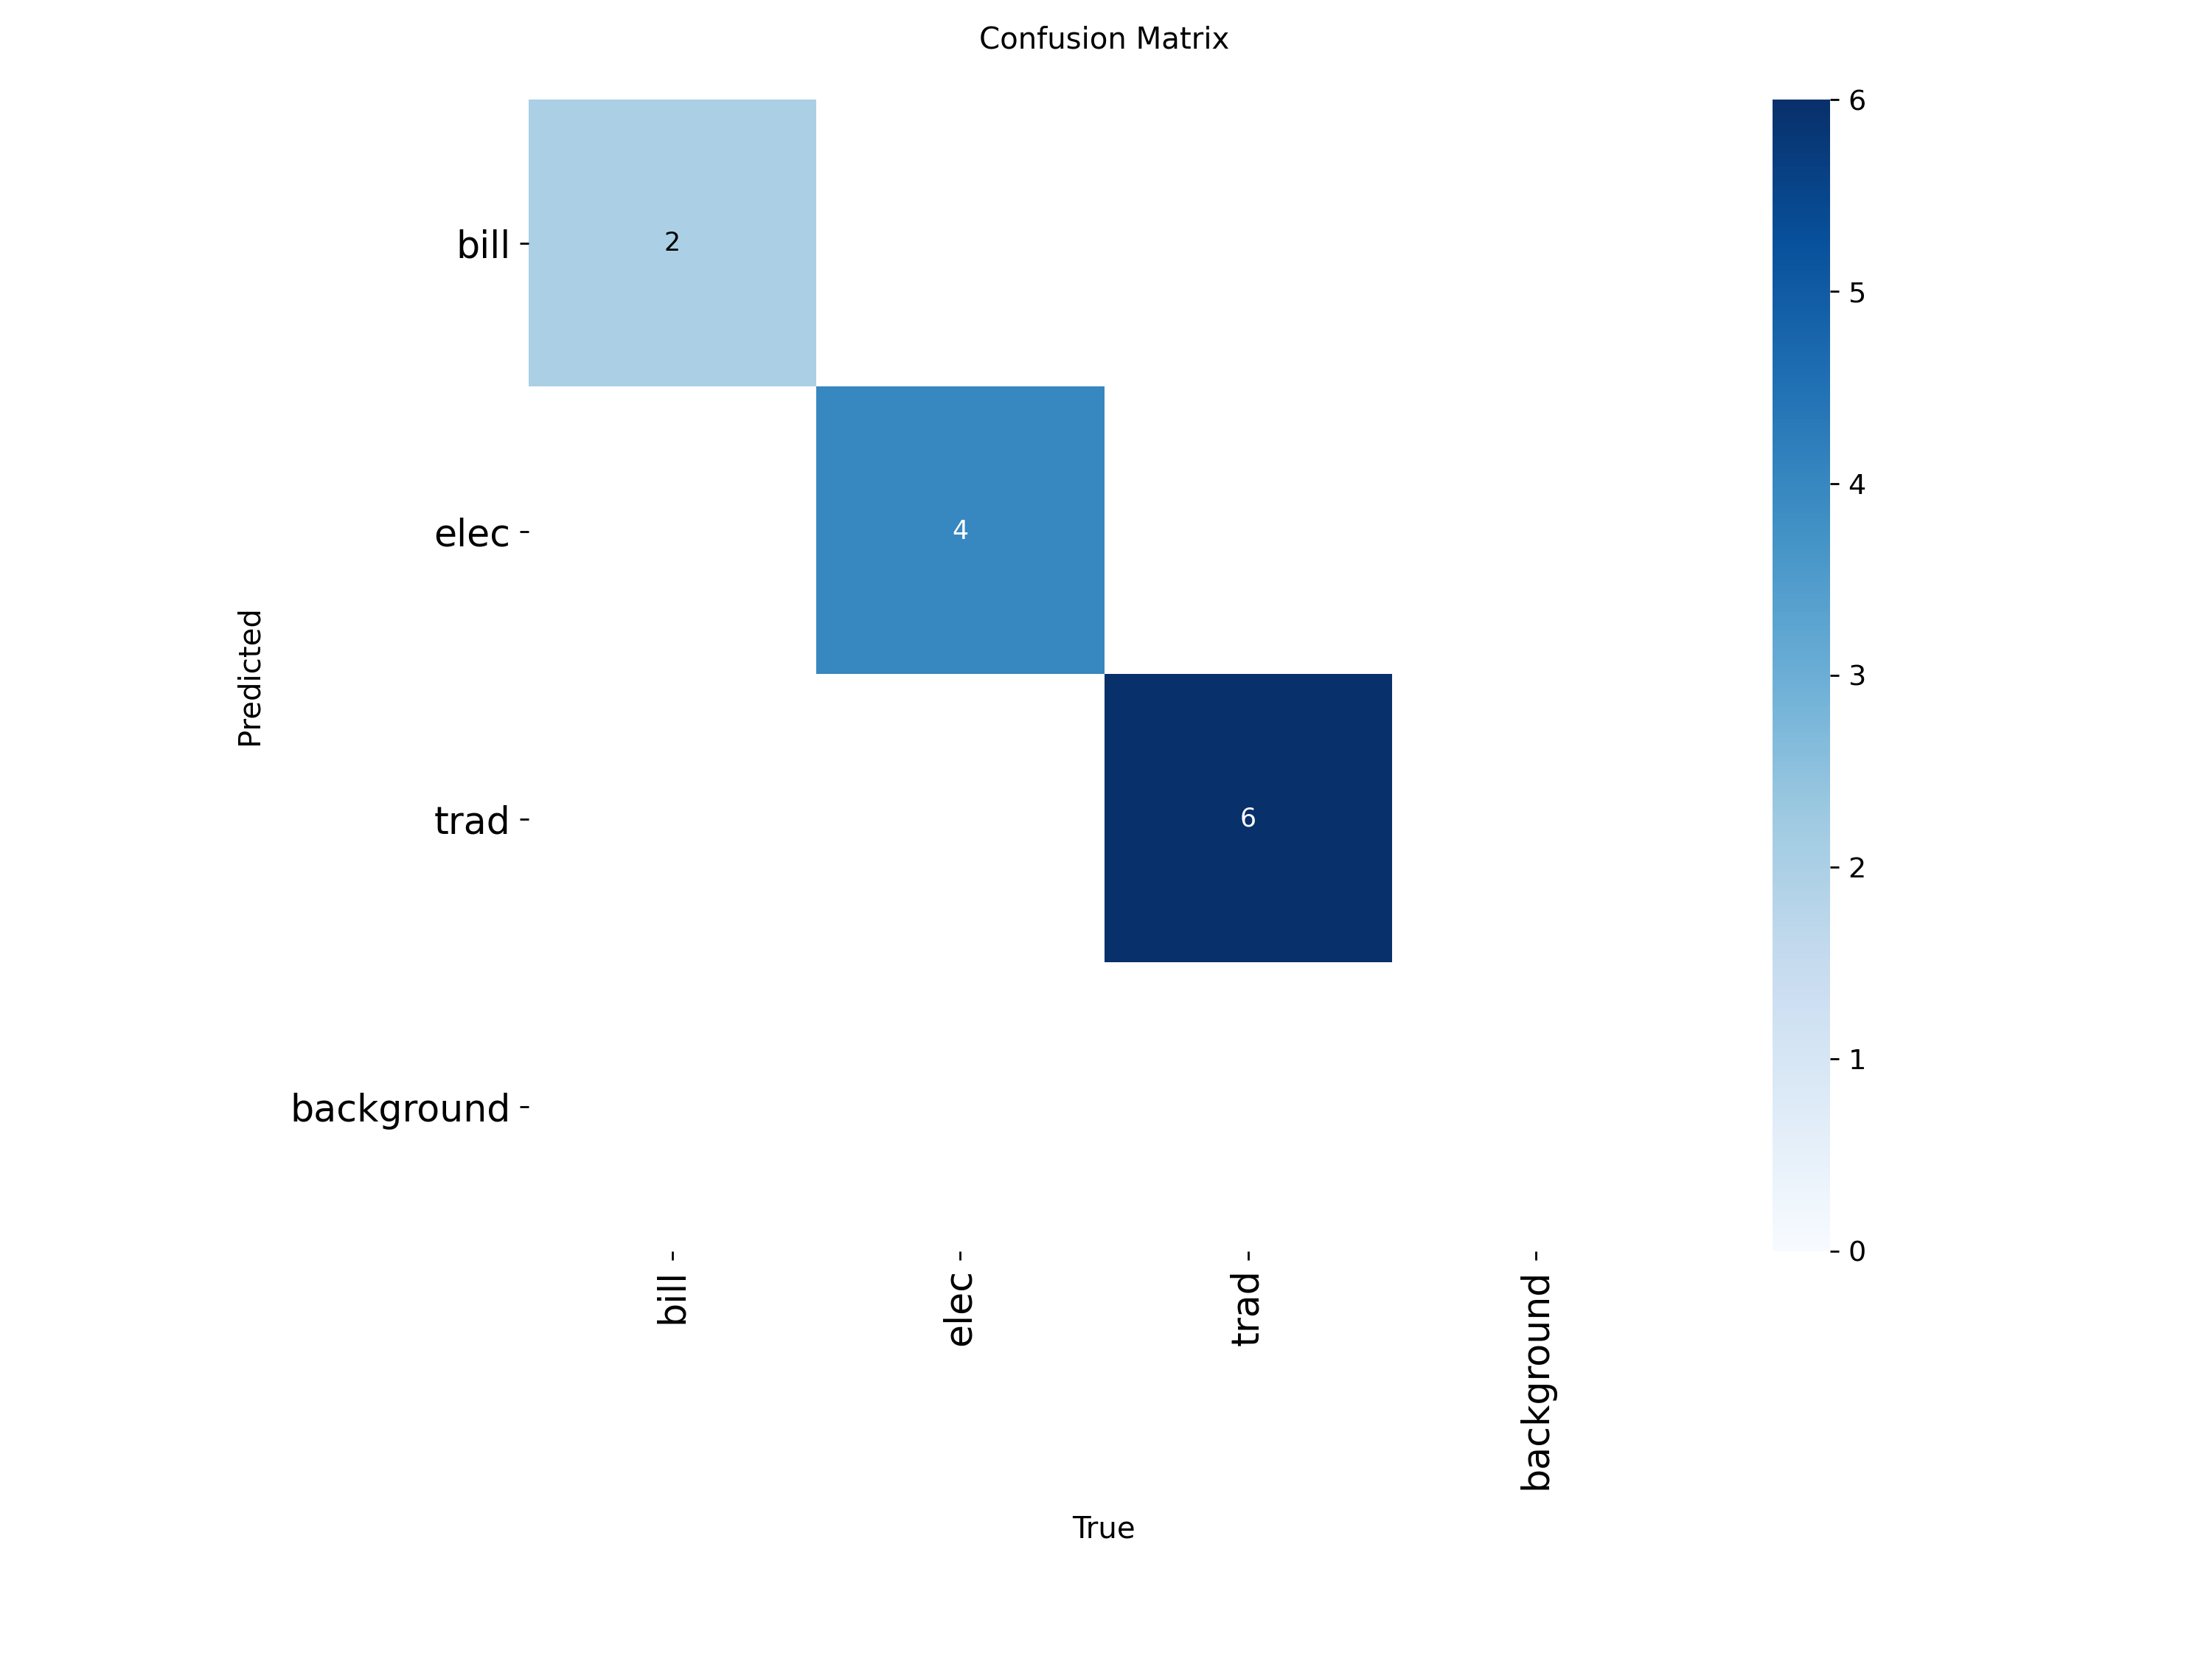

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

/content


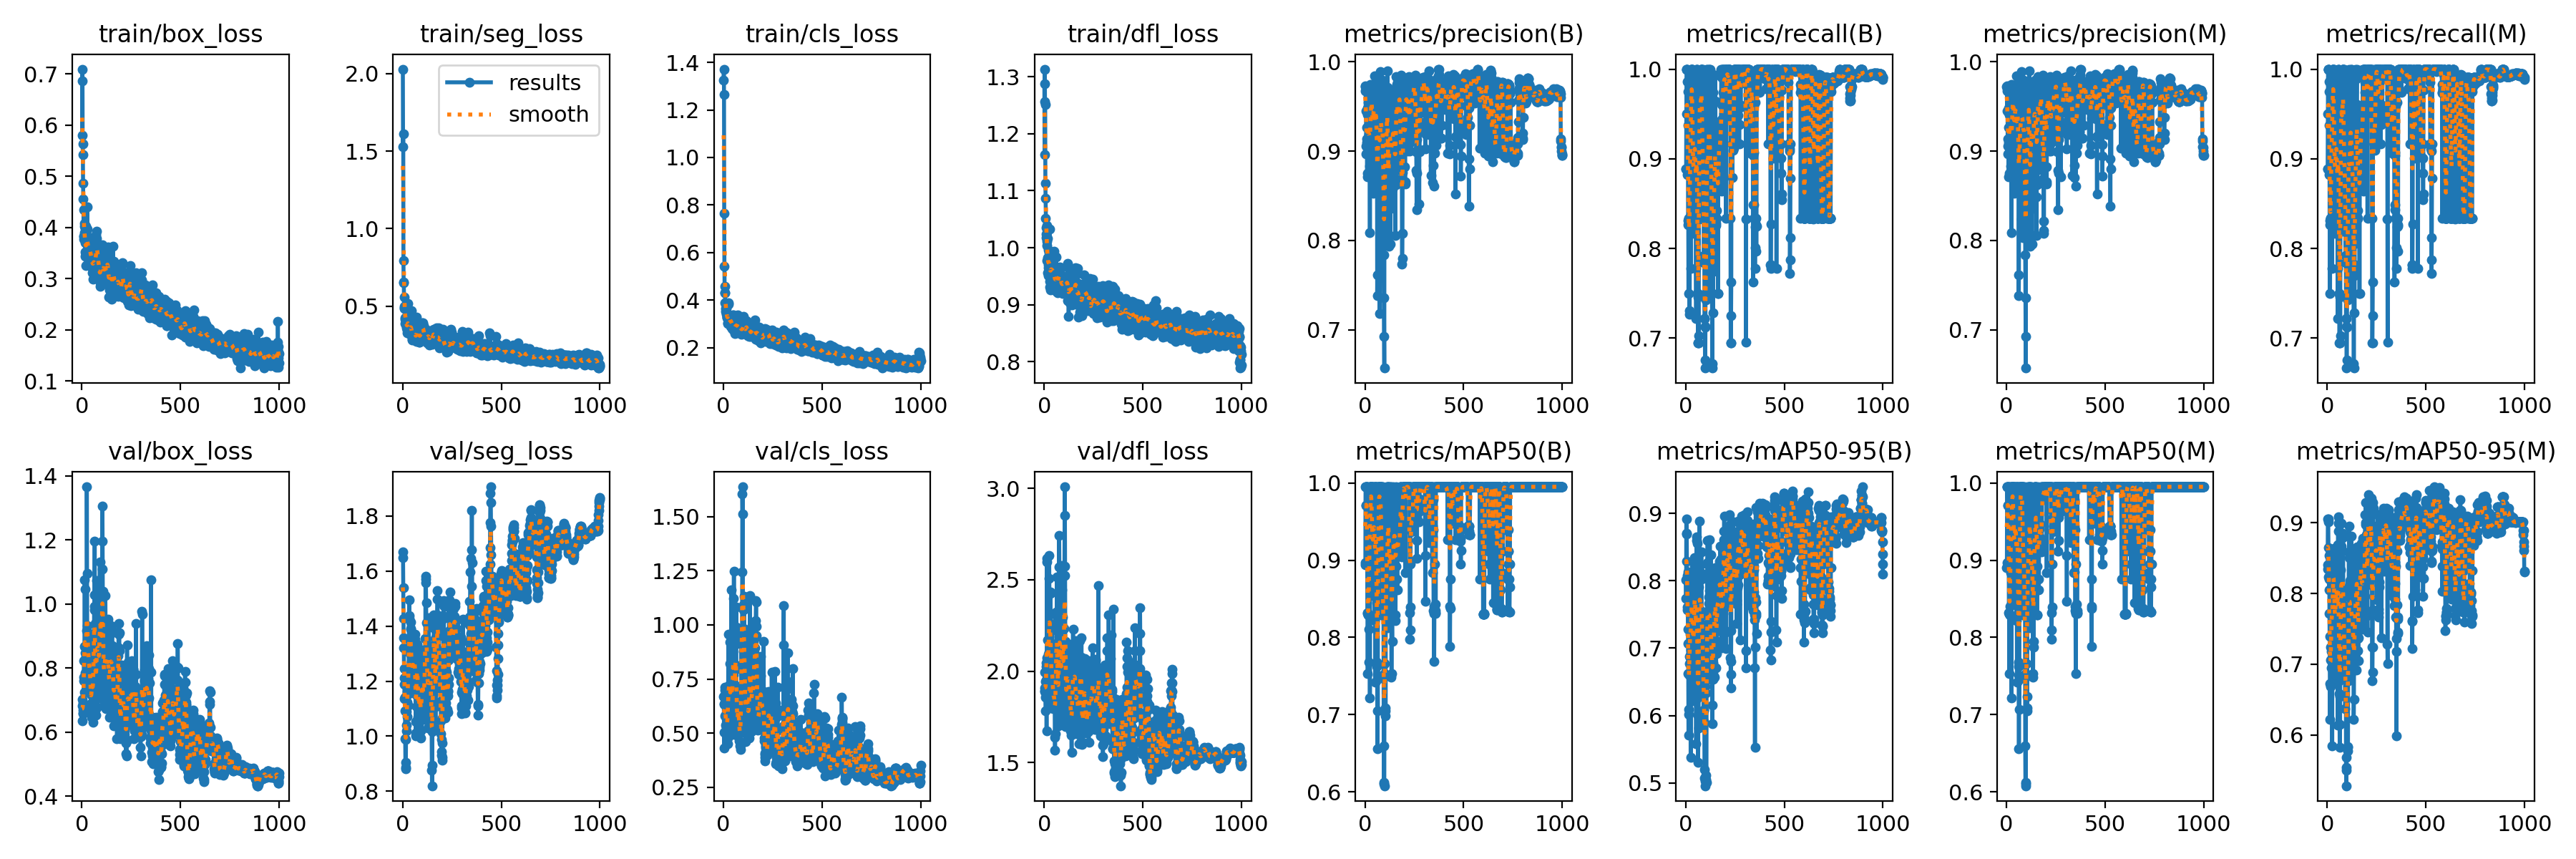

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/results.png', width=600)

/content


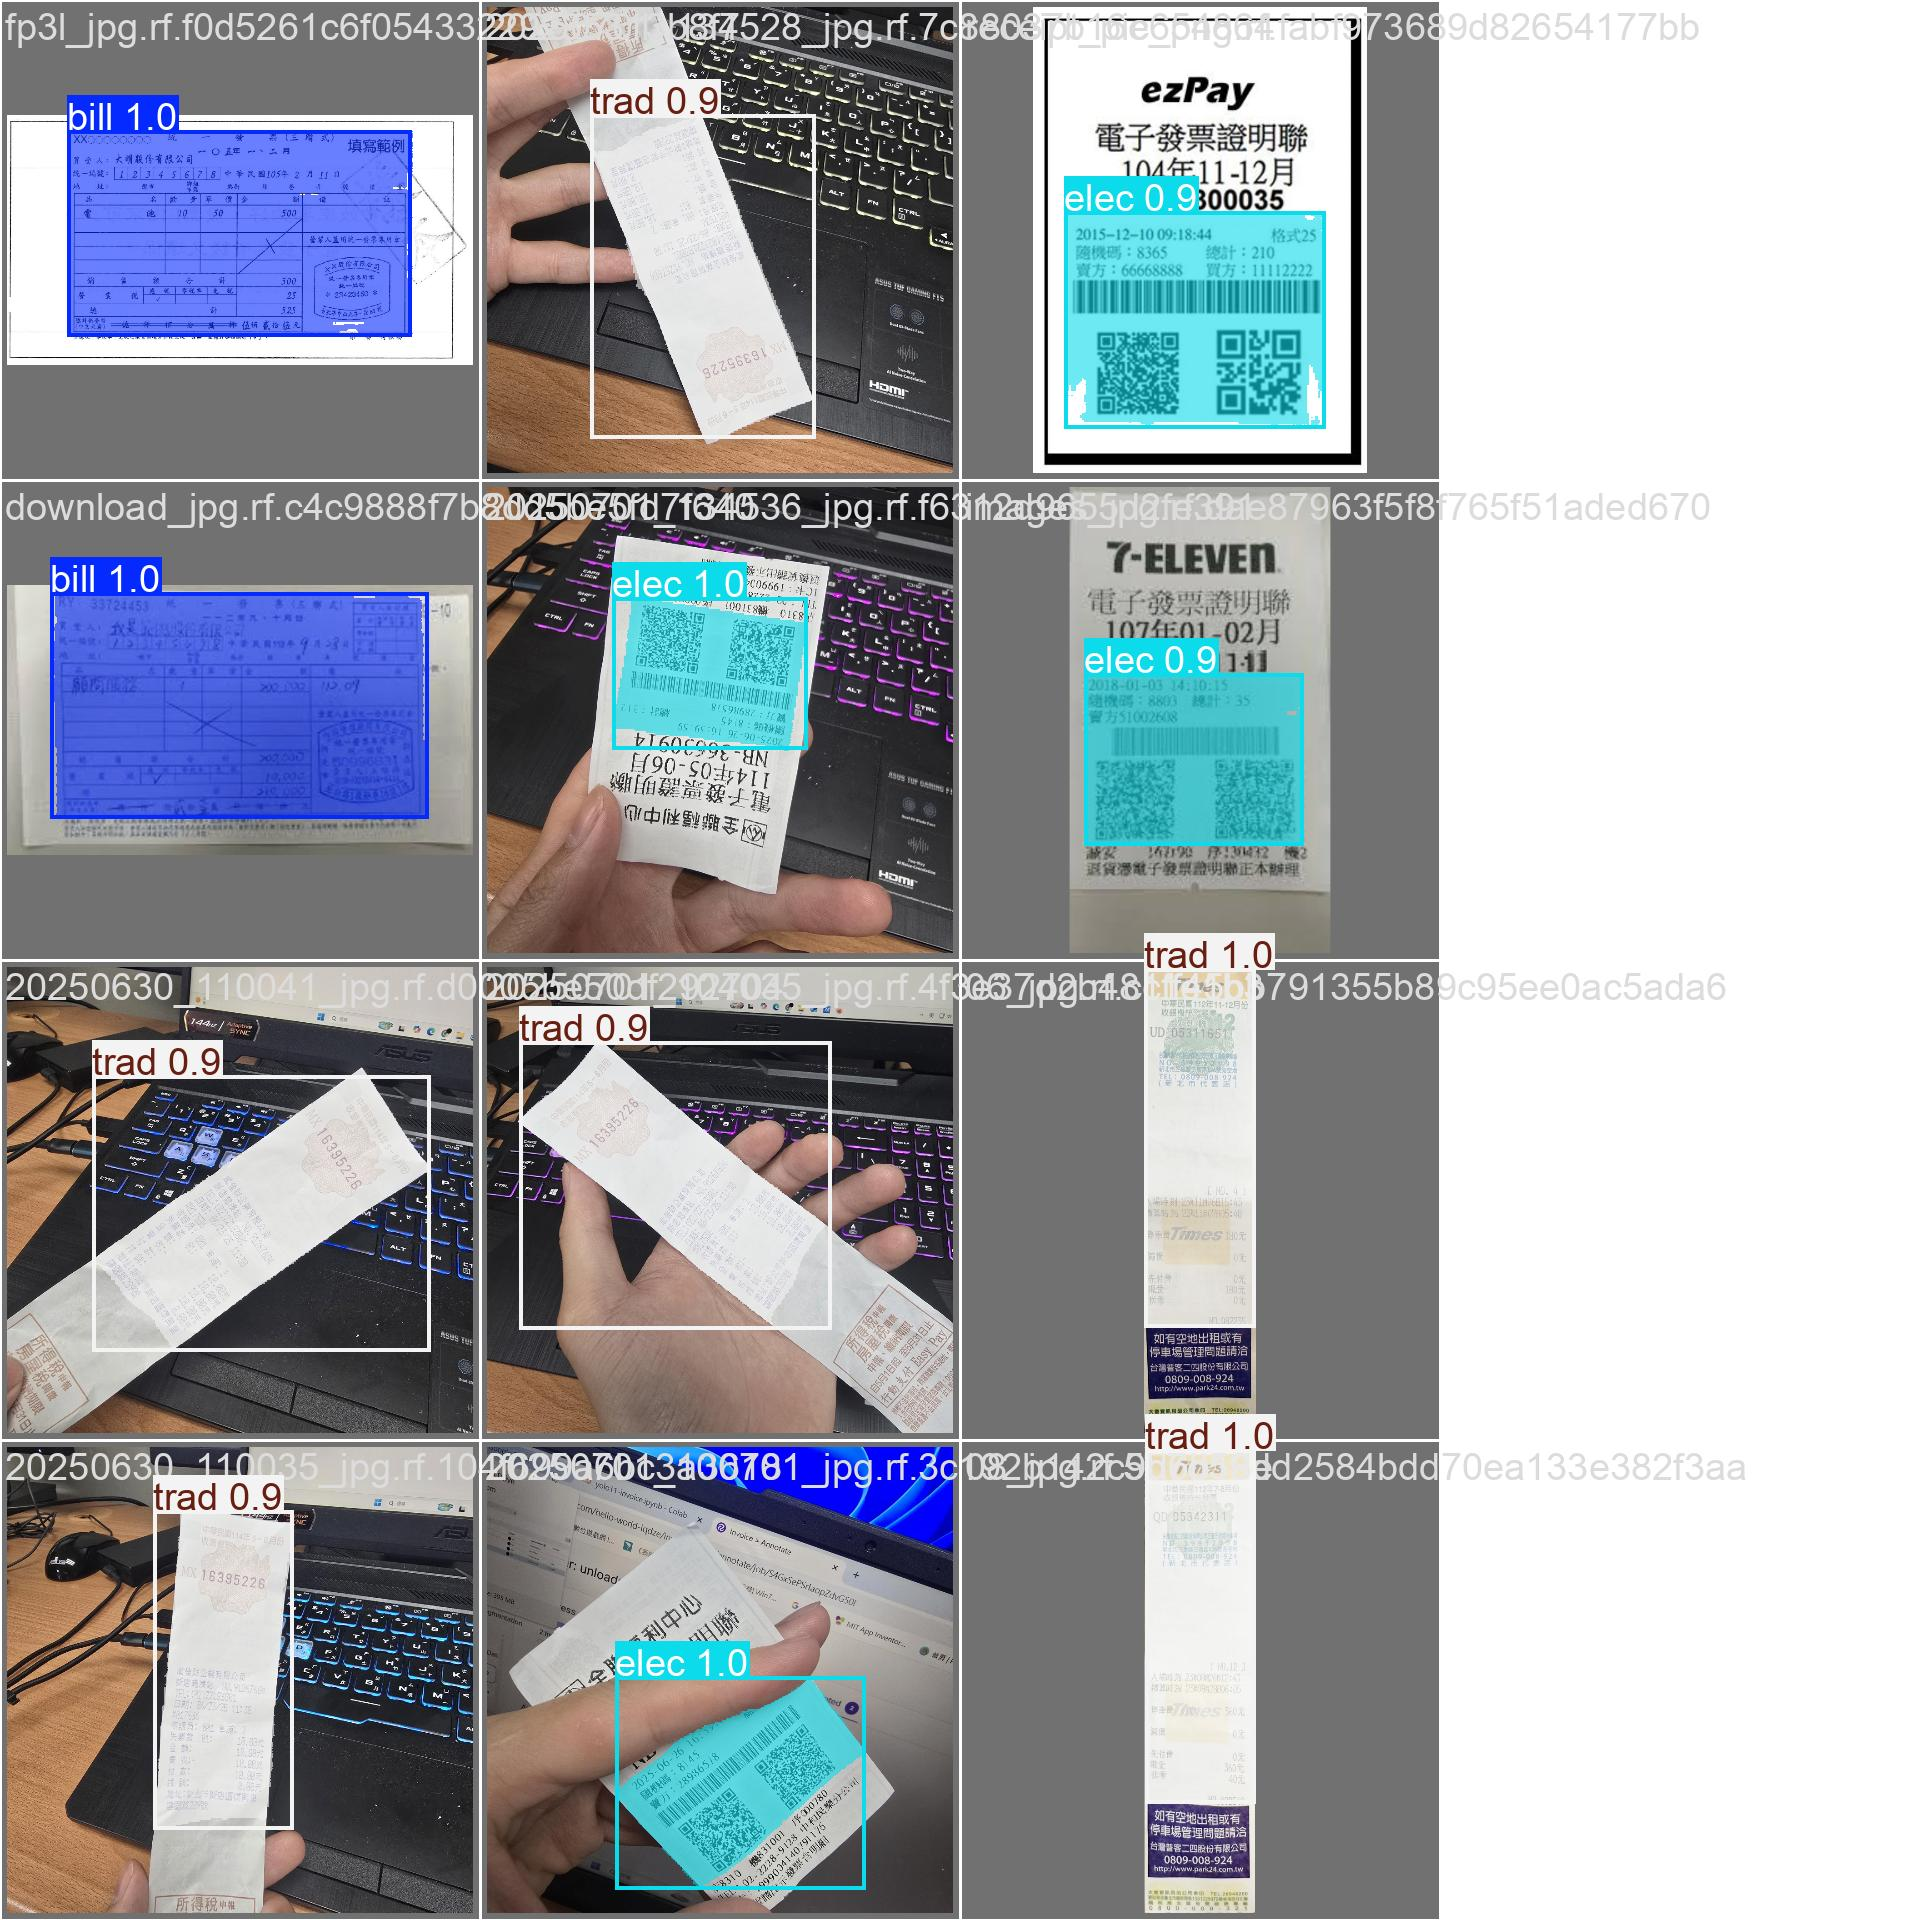

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

In [ ]:
%cd {HOME}
model_path = '/content/runs/segment/train/weights/best.pt'
source_path = f'/content/datasets/Invoice-{datasets_version}/test/images'
print(f"模型位置: {model_path}\n測試檔案位置: {source_path}\n")
!yolo task=segment mode=predict model={model_path} conf=0.5 source={source_path} save=true

/content
前次訓練資料位置: /content/runs/segment/train/weights/best.pt
測試檔案位置: /content/datasets/Invoice-15/test/images

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,153 parameters, 0 gradients, 10.2 GFLOPs

image 1/3 /content/datasets/Invoice-15/test/images/20250630_110401_jpg.rf.e1598ba18cb1212806cc0231e377871b.jpg: 1024x1024 1 trad, 18.3ms
image 2/3 /content/datasets/Invoice-15/test/images/ip_e-invoice_b_jpg.rf.5acc7c37d254c92e5fb41afd0c4a977b.jpg: 576x1024 1 elec, 50.5ms
image 3/3 /content/datasets/Invoice-15/test/images/vat_calculator_01_jpg.rf.85fc8a9455a4b7be430f5ae9d738843c.jpg: 672x1024 1 bill, 52.1ms
Speed: 6.4ms preprocess, 40.3ms inference, 53.3ms postprocess per image at shape (1, 3, 672, 1024)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


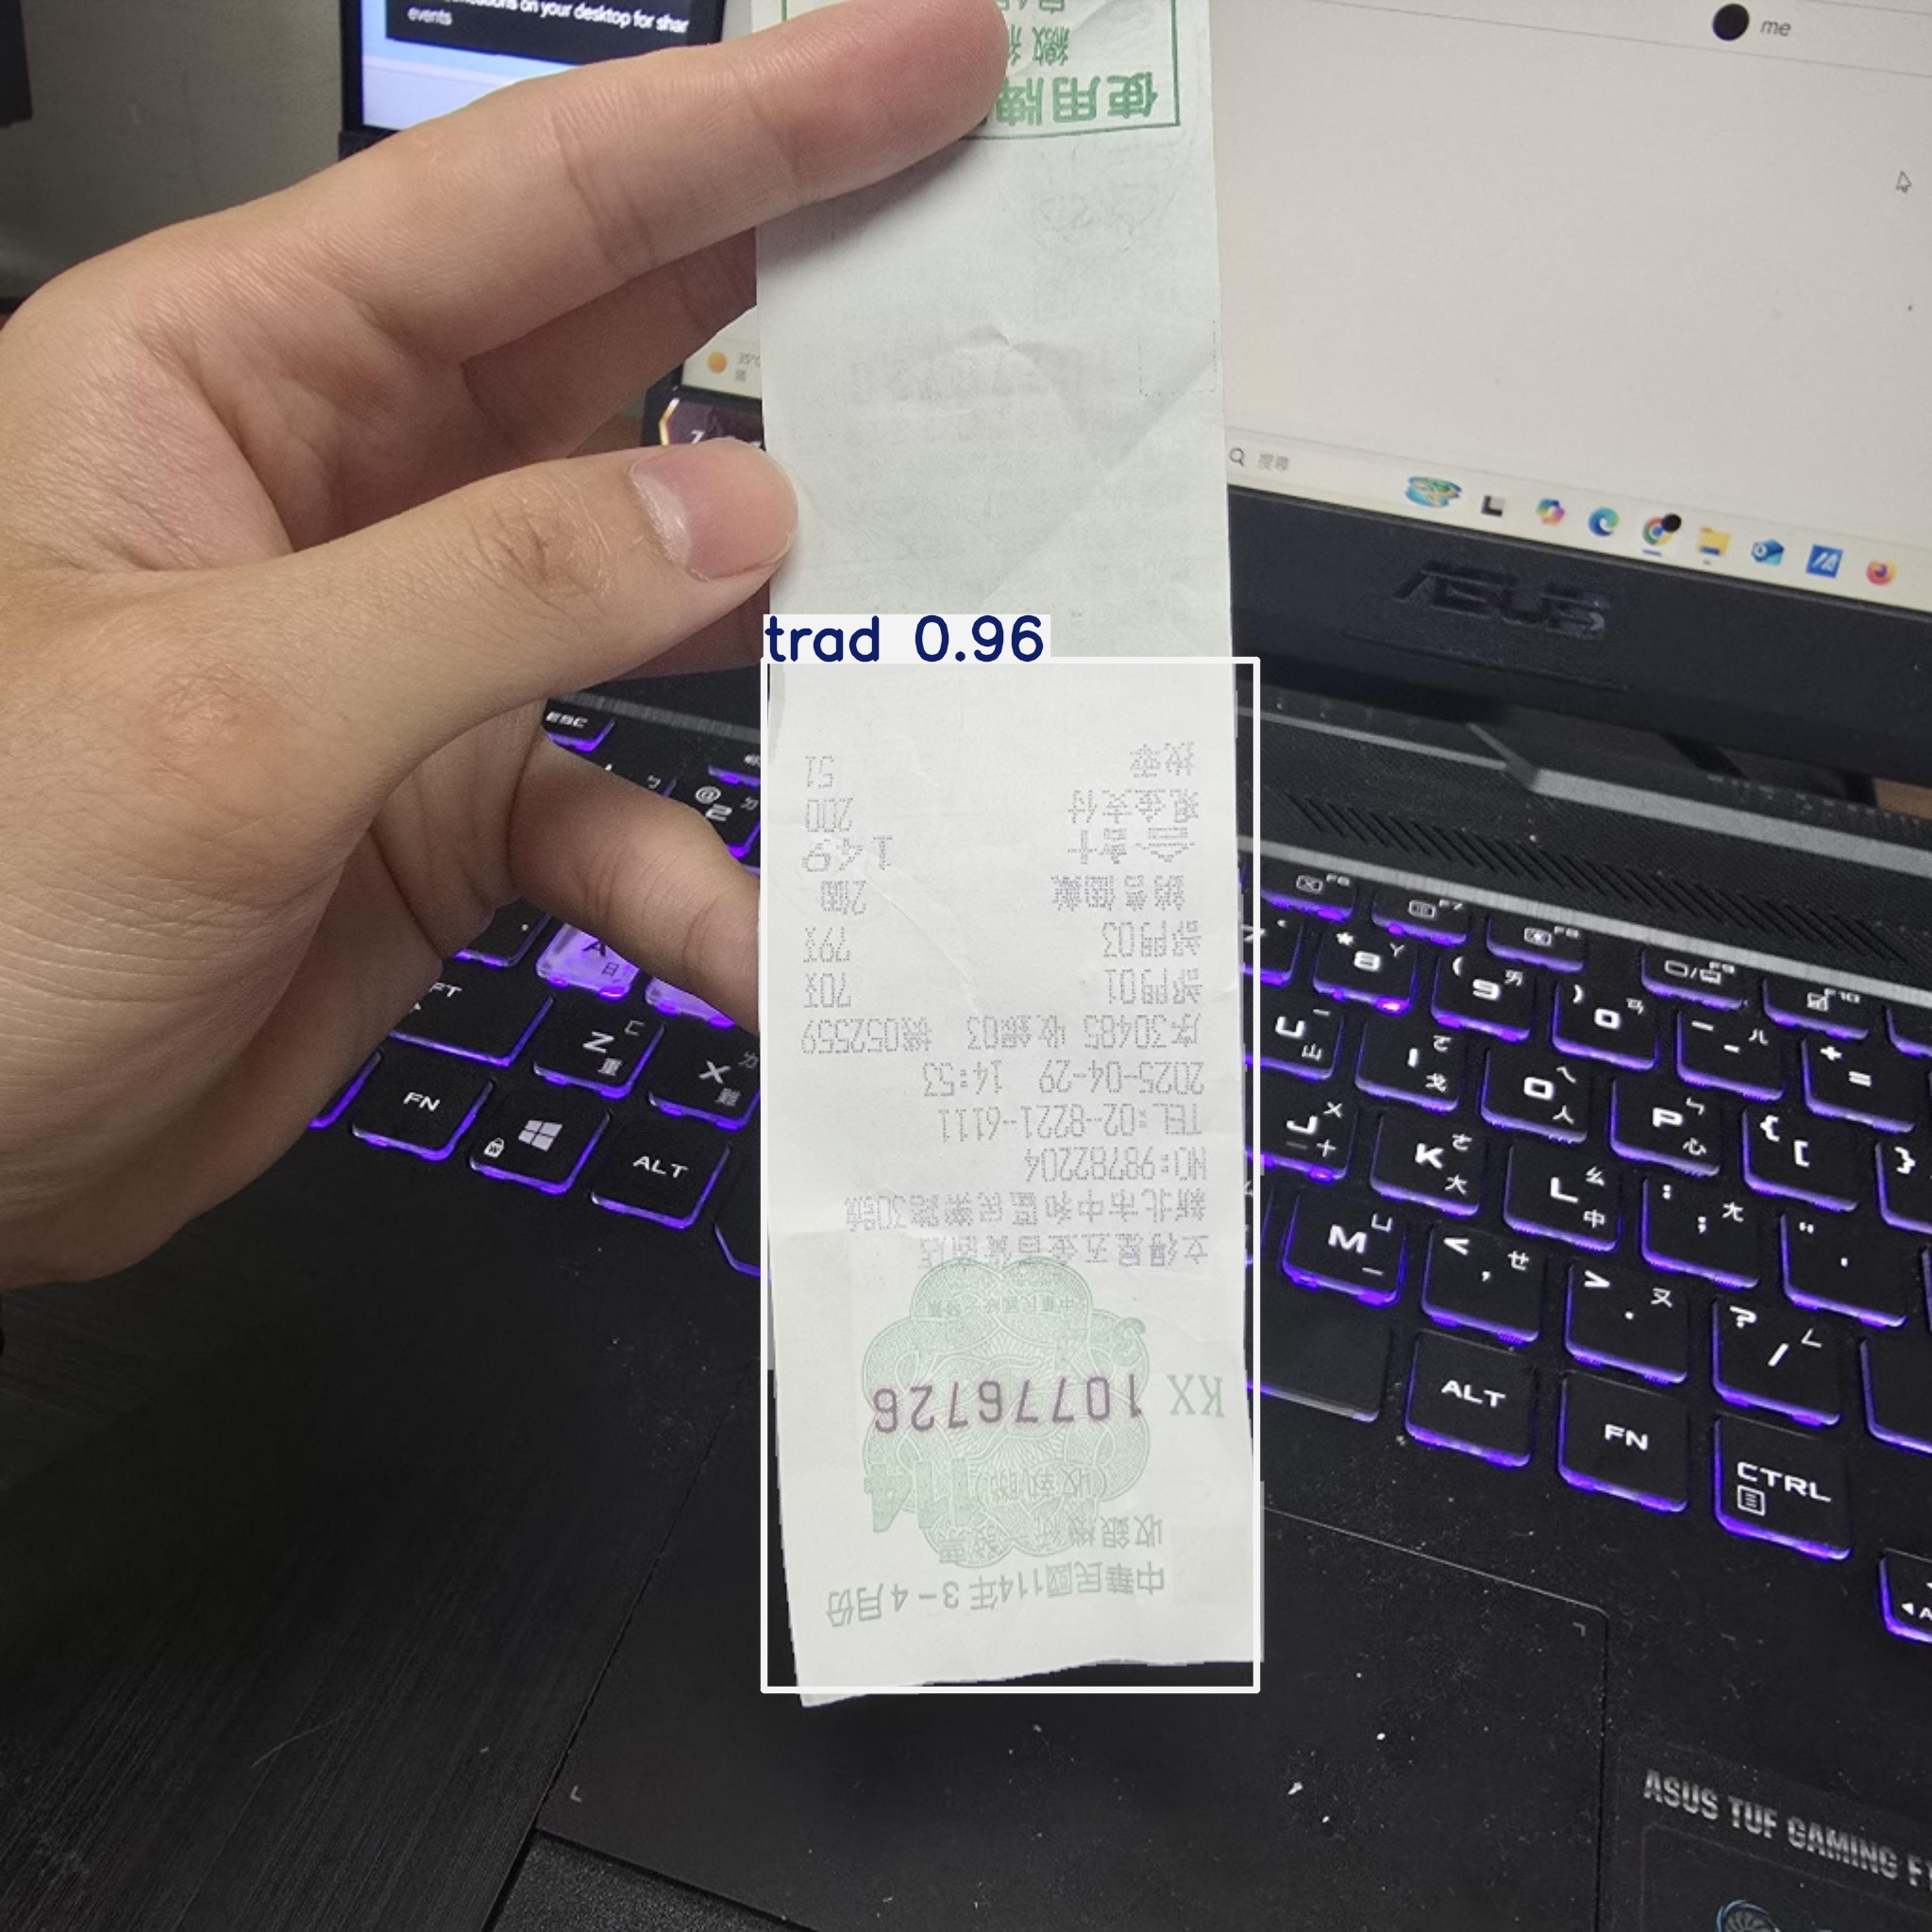

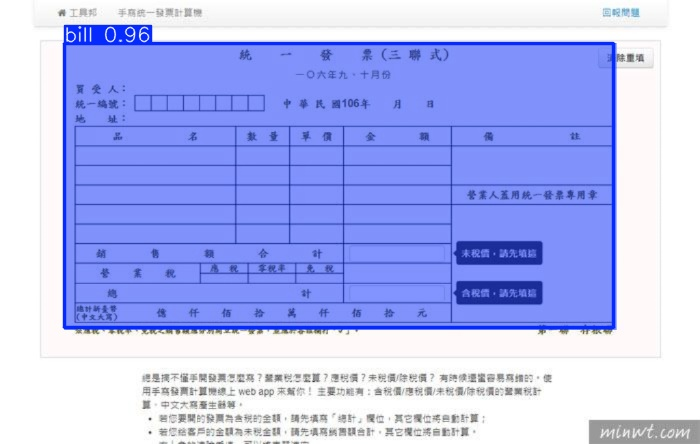

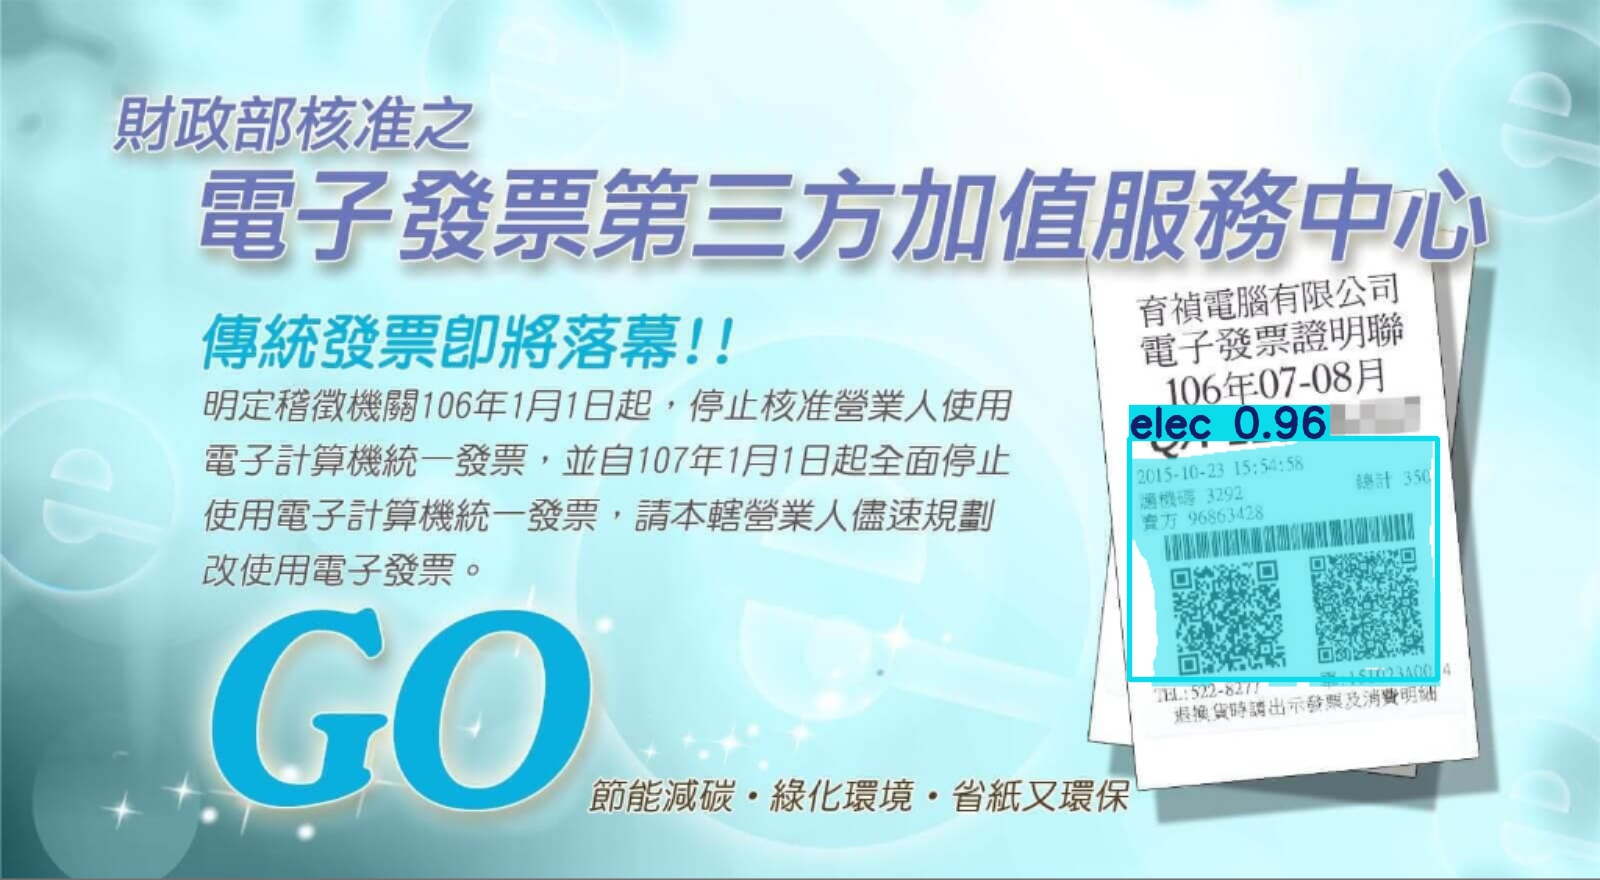

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict/*.jpg')[:10]:
      display(Image(filename=image_path, height=600))
      print("\n")

In [ ]:
# local video path or youtube video link
# source 放影片路徑
!yolo task=detect mode=predict model=/content/runs/segment/train/weights/best.pt conf=0.25 source=/content/drive/MyDrive/sharingColab/yolo11/cats_dogs_video.mp4 save=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,590 parameters, 0 gradients, 35.3 GFLOPs

video 1/1 (frame 1/702) /content/drive/MyDrive/sharingColab/yolo11/cats_dogs_video.mp4: 480x800 1 cat, 67.8ms
video 1/1 (frame 2/702) /content/drive/MyDrive/sharingColab/yolo11/cats_dogs_video.mp4: 480x800 1 cat, 20.2ms
video 1/1 (frame 3/702) /content/drive/MyDrive/sharingColab/yolo11/cats_dogs_video.mp4: 480x800 1 cat, 20.2ms
video 1/1 (frame 4/702) /content/drive/MyDrive/sharingColab/yolo11/cats_dogs_video.mp4: 480x800 1 cat, 1 dog, 20.1ms
video 1/1 (frame 5/702) /content/drive/MyDrive/sharingColab/yolo11/cats_dogs_video.mp4: 480x800 1 cat, 20.0ms
video 1/1 (frame 6/702) /content/drive/MyDrive/sharingColab/yolo11/cats_dogs_video.mp4: 480x800 1 cat, 1 dog, 20.0ms
video 1/1 (f

In [ ]:
#把影片存到Google Drive
!cp /content/runs/segment/predict2/cats_dogs_video.avi /content/drive/MyDrive/sharingColab/yolo11/segmentation/yolov11s_seg